In [1]:
import carla
import random
import math
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython import display

from lane_detection import LaneDetection
from lateral_control import LateralController
from waypoint_prediction import waypoint_prediction, target_speed_prediction



In [2]:
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
# world = client.get_world()
world = client.load_world('Town03')


weather = carla.WeatherParameters(
    cloudiness=80.0,
    precipitation=30.0,
    sun_altitude_angle=90.0)

world.set_weather(weather)

blueprint_library = world.get_blueprint_library()
spawn_points = world.get_map().get_spawn_points()

vehicle_bp = blueprint_library.find('vehicle.tesla.model3')
vehicle = world.try_spawn_actor(vehicle_bp, random.choice(spawn_points))

spectator = world.get_spectator()
print(vehicle.get_transform().rotation.pitch)
transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-8, y=0, z=20), ), carla.Rotation(pitch=-45.000000, yaw=vehicle.get_transform().rotation.yaw, roll=0.000000))
spectator.set_transform(transform)

0.0


In [3]:
# for i in range(30):
#     vehicle_bp = random.choice(blueprint_library.filter('vehicle.*'))
#     npc = world.try_spawn_actor(vehicle_bp, random.choice(spawn_points))

# for v in world.get_actors().filter('vehicle.*'):
#     v.set_autopilot(True)

In [4]:
def process_image(image, vehicle, LD_module, LatC_module, fig):
    i = np.array(image.raw_data)
    i2 = i.reshape((image.height, image.width, 4))
    i3 = i2[:, :, :3]
#     cv2.imwrite('output/%06d.jpg' % image.frame, i3)
#     start = time.time()
    bev = LD_module.front2bev(i3)
#     cv2.imwrite('output/%06d_bev.jpg' % image.frame, bev)

    lane1, lane2 = LD_module.lane_detection(bev)
    waypoints = waypoint_prediction(lane1, lane2, way_type='center')
    target_speed = target_speed_prediction(waypoints)
    
    plt.ion()
    plt.show()
    LD_module.plot_state_lane(bev, 0, fig, waypoints=waypoints)
    display.clear_output(wait=True)
    
    velocity = vehicle.get_velocity()
    speed = np.hypot(velocity.x, velocity.y)
#     print(speed)
#     if not image.frame <100:
    steering = LatC_module.stanley(waypoints, target_speed)
#     print(steering)

    control = carla.VehicleControl()

    control.steer = steering
    control.throttle = 0.2
    vehicle.apply_control(control)
    
#     print('Time Taken: ',time.time()-start)
#     cv2.imwrite('bev/%06d.jpg' % image.frame, bev)


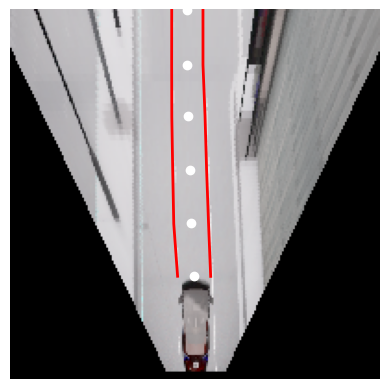

In [5]:
camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '480')
camera_bp.set_attribute('image_size_y', '270')
camera_bp.set_attribute('fov', '64')
camera_init_trans = carla.Transform(carla.Location(x=-5.5, z=2.5), carla.Rotation(pitch=8.0))
camera = world.spawn_actor(camera_bp, camera_init_trans, attach_to=vehicle, attachment_type=carla.AttachmentType.SpringArm)

fig = plt.figure()



LD_module = LaneDetection()
LatC_module = LateralController()

camera.listen(lambda image: process_image(image, vehicle, LD_module, LatC_module, fig))

In [ ]:
# camera.stop()